In [1]:
using Plots

In [2]:
function get_moore_neighbors(i,j,grid)
    """
    return the  values of the moore neighborhood of a given cell at location i,j
    inputs:
        i<int>: the x index of the cell we want to pick 
        j<int>: the y index of the cell we want to pick 
        grid<NxN matrix>: the actual state of the celluar automata, we will pick the grid[i,j] to be the cell we look at
    returns: 
        neighbors<matrix>: an 2d matrix of the values of the 8 cells in the Moore neighborhood of cell i,j
    """
    values = [mod1.(x .+ [-1,0,1], size(grid)[1]) for x in 1:length(grid)]
    neighbors = grid[values[i],values[j]]
end

function get_von_neumann_neighbors(i,j,grid)
    """
    return the  values of the von neuman neighborhood of a given cell at location i,j
    inputs:
        i<int>: the x index of the cell we want to pick 
        j<int>: the y index of the cell we want to pick 
        grid<NxN matrix>: the actual state of the celluar automata, we will pick the grid[i,j] to be the cell we look at
    returns: 
        neighbors<array>: an array of the values of the 4 cells in the von neuman neighborhood of cell i,j
    """
    values = [mod1.(x .+ [-1,0,1], size(grid)[1]) for x in 1:length(grid)]
     values_i = grid[i,values[j]]
     values_j = grid[values[i],j]
     return cat(values_i,values_j)
end

function game_of_life_update(neighborhood)
    """
    Given an array of values of the neighborhood of a cell, calculate the updated value of the cell according to Conway's Game of life: https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life
    inputs:
        neighborhood<matrix> a matrix of the neighborhood around a cell
    returns: 
        return_condition<int>: the conidition of the updated cell at index i,j, 0 if dead, 1 if alive
    """
    my_cell = neighborhood[2,2]
    return_condition = 0#the state of the current cell to reuturn from this function

    #if the cell is alive
    if my_cell == 1
        alive_neighbors = sum(neighborhood)-1#the number of neighbors who are alive_neighborohood, subtract one to account for the cell itself.
        #determine status of current cell based on status of neighboring cells
        if 1 < alive_neighbors < 4 #if the number of alive_neighbors is equal to 2 or 3, the cel remains alive
            return_condition = 1
        end
    end
    #if cell is dead 
    if my_cell == 0
        alive_neighbors = sum(neighborhood)
        if alive_neighbors == 3
            return_condition = 1
        end
    end
    
#println(return_condition)
return return_condition
end

### This cell sets up the Moore and von Neumann Neighborhoods and also the original game of life rules

game_of_life_update (generic function with 1 method)

In [3]:
function run_ca_simulation(grid_0,update_func ,num_generations)
    """
    takes in an initial callular automota state, an updating rule and run a CA simulation for <num_generations>
    inputs: 
        grid_0<NxN martrix>: an NxN matrix which is the inital state of the CA
        update_func<function> this is the function, like <game_of_life_update> that will determine how the CA is updated
        num_generations<int>: the number of generations of the model to run
    returns: 
        grid_history<NxNxnum_generations matrix>: this is a matrix where every NxN 2d slice is the state of the CA at one time step. The entire 3d matrix stores the history of the ca_gif
    """
    N = size(grid_0)[1]
    grid_history = zeros(Int8,N,N,num_gens)
    grid_history[:,:,1] = grid_0#the first entry in our grid history will be the inital conditions
    grid = grid_0 

    for gen in 2:num_gens#for each generation
        next_grid =zeros(Int8,N,N) #create a new grid
        for (i,j) in Tuple.(CartesianIndices(grid))#for each cell in the gird
            neighborhood = get_moore_neighbors(i,j,grid)#get the neighborhood of that cell
            #println(neighborhood)
            next_grid[i,j] = update_func(neighborhood)#calculate the state of cell i,j based on the updating rule
        end
        grid_history[:,:,gen] = next_grid#save in the history
        grid = next_grid
    end
    return grid_history
end

### This cell runs the CA model and returns a 3-d matrix where a slice is a snapshot of the CA at that time
### and this 3-d matrix can and is made into a gif

run_ca_simulation (generic function with 1 method)

In [4]:
function plot_ca(grid_history,file_name,fps =10)
    """
    Takes in a NxNxnum_gens 3d array of grid histories and creates an animation 
    inputs:
        grid_history<matrix>: this is a matrix where every NxN 2d slice is the state of the CA at one time step. The entire 3d matrix stores the history of the ca_gif
        file_name<string>: the resulting animation will be saved as a gif with this file name 
    output:
        ca_fig<gif>: returns the sequence of CA generations as an animated gif. 
    """
    num_gens = size(grid_history)[3]#get the number of frames from the size of the matrix, one frame per generation
    anim = @animate for frame in 1:num_gens#create a heatmap for each frame of the animation
        heatmap(grid_history[:,:,frame],xaxis = false,yaxis=false,legend = false,ticks=false,background_color_outside = "white",figsize = (15,15),c=:binary)
    end
    ca_gif = gif(anim,file_name,fps=fps)#create a gif from all these heatmaps
    return ca_gif
end

### This cells takes the 3-d matrix and animates it to show a gif of what happens in the CA

plot_ca (generic function with 2 methods)

In [58]:
function calculate_hamming_grid_hamming_dist(grid_a,grid_b)
    """
    calculates the hamming distance between to NxN grids, each one timestep in a CA simulation
    """
    diff = grid_a-grid_b
    sum(broadcast(abs,diff))
end

function calculate_occupancy(grid_history)
    """
    takes in a NxNxnum_gens array of CA grid history
    returns the hamming distance between each pair of grids i and i+1
    """
    N = size(grid_history)[1]
    grid_size = N*N#the total number of cells

    occupancy_array = []
    
    for i in 1:num_gens
        grid_a = grid_history[:,:,i]
        grid_sum = sum(grid_a)
        occupancy_i = grid_sum/grid_size

        push!(occupancy_array,occupancy_i)
    end
    return occupancy_array
end

function calculate_hamming_ts(grid_history)
    """
    takes in a NxNxnum_gens array of CA grid history
    returns the hamming distance between each pair of grids i and i+1
    """
    hamminmg_dist_array = []
    for i in 2:(num_gens)
        grid_a = grid_history[:,:,i]
        grid_b = grid_history[:,:,i-1]
        hamming_dist_i = calculate_hamming_grid_hamming_dist(grid_a,grid_b)

        push!(hamminmg_dist_array,hamming_dist_i)
    end
    return hamminmg_dist_array
end


calculate_hamming_ts (generic function with 1 method)

In [59]:
calculate_occupancy(test1_history)

100-element Vector{Any}:
 0.0208
 0.024
 0.0192
 0.0256
 0.0208
 0.0208
 0.0304
 0.0256
 0.0336
 0.04
 ⋮
 0.0768
 0.072
 0.0672
 0.08
 0.0672
 0.0656
 0.0672
 0.0736
 0.0624

In [60]:
size(test1_history)

(25, 25, 100)

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original GoL inf pattern1.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original GoL inf pattern1.gif")
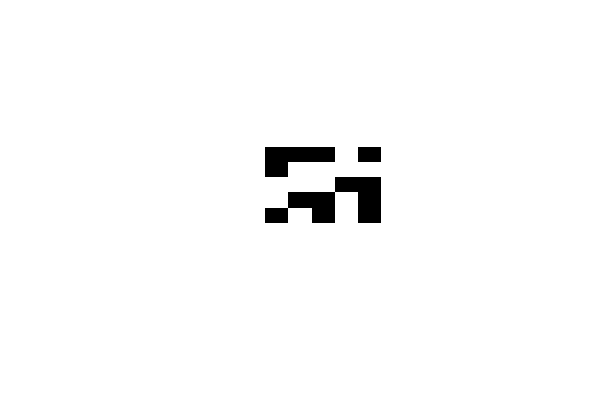

In [93]:
#Lets take an example

N = 25#the size of our grid
num_gens = 100#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our cellular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4#the end of the pattern, here 4 is the length and width of the pattern we want to insert
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1;0 1 1 0 1; 0 0 0 1 1;1 0 0 0 0;1 1 1 0 1]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix

test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original GoL inf pattern1.gif")

In [97]:
init_cond = heatmap(test1_history[:,:,1],xaxis = false,yaxis=false,legend = false,ticks=false,background_color_outside = "white",figsize = (15,15),c=:binary)
savefig("infinite_pattern1_init_cond.png")

In [94]:
#make hamming distance plot
title = "Original GoL inf pattern1"
filename = "$(title).png"
hamming_ts = calculate_hamming_ts(test1_history)
occupancy_ts = calculate_occupancy(test1_history)
hamming_plot = plot(hamming_ts,title = title,xlabel = "timestep",ylabel = "Hamming Distance")
occupancy_plot = plot(occupancy_ts,title = title,xlabel = "timestep",ylabel = "Occupancy Plot")
final_plot = plot(hamming_plot,occupancy_plot,figsize = (20,5))
savefig(final_plot,filename)

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original Gol 4 blinkers.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original Gol 4 blinkers.gif")
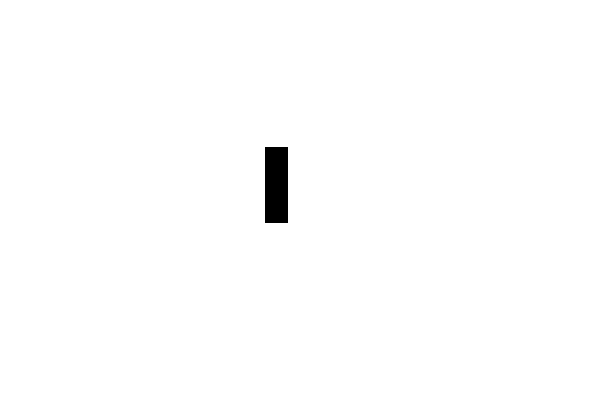

In [72]:
N = 25#the size of our grid
num_gens = 30#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin] = [1 1 1 1 1]
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original Gol 4 blinkers.gif")

In [75]:
#make hamming distance plot
title = "Original GoL 4 blinkers"
filename = "$(title).png"
hamming_ts = calculate_hamming_ts(test1_history)
occupancy_ts = calculate_occupancy(test1_history)
hamming_plot = plot(hamming_ts,title = title,xlabel = "timestep",ylabel = "Hamming Distance")
occupancy_plot = plot(occupancy_ts,title = title,xlabel = "timestep",ylabel = "Occupancy Plot")
final_plot = plot(hamming_plot,occupancy_plot,figsize = (20,5))
savefig(final_plot,filename)

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original Gol inf pattern2.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original Gol inf pattern2.gif")
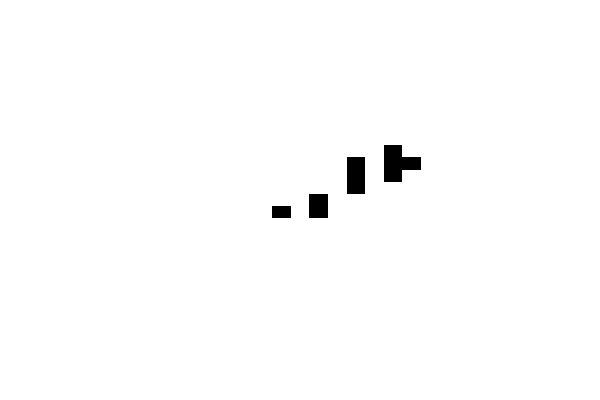

In [105]:
N = 31 #the size of our grid
num_gens = 200 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+7#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 0 0 0 0 ;0 0 1 0 0 0 0 0 ;0 0 0 0 1 0 0 0 ;0 0 0 0 1 0 1 0 ;0 0 0 0 1 0 1 1 ;0 0 0 0 0 0 1 0 ;0 0 0 0 0 0 0 0 ;0 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original Gol inf pattern2.gif")

In [106]:
#make hamming distance plot
title = "Original GoL inf pattern2_N_31_gen_200"
filename = "$(title).png"
hamming_ts = calculate_hamming_ts(test1_history)
occupancy_ts = calculate_occupancy(test1_history)
hamming_plot = plot(hamming_ts,title = title,xlabel = "timestep",ylabel = "Hamming Distance")
occupancy_plot = plot(occupancy_ts,title = title,xlabel = "timestep",ylabel = "Occupancy Plot")
final_plot = plot(hamming_plot,occupancy_plot,figsize = (20,5))
savefig(final_plot,filename)

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original Gol inf pattern3.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original Gol inf pattern3.gif")
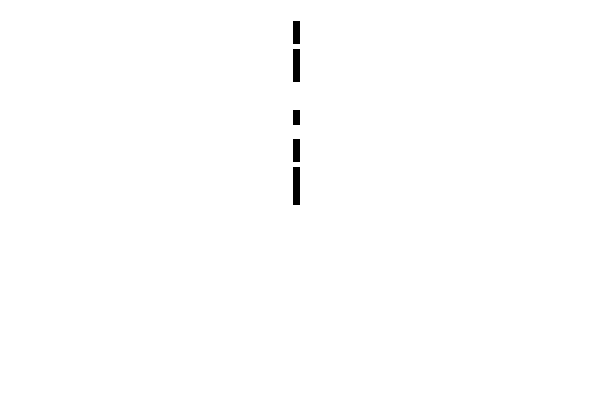

In [78]:
N = 80 #the size of our grid
num_gens = 50 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+38#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin] = [1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 ]
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original Gol inf pattern3.gif")

In [80]:
#make hamming distance plot
title = "Original GoL inf pattern3"
filename = "$(title).png"
hamming_ts = calculate_hamming_ts(test1_history)
occupancy_ts = calculate_occupancy(test1_history)
hamming_plot = plot(hamming_ts,title = title,xlabel = "timestep",ylabel = "Hamming Distance")
occupancy_plot = plot(occupancy_ts,title = title,xlabel = "timestep",ylabel = "Occupancy Plot")
final_plot = plot(hamming_plot,occupancy_plot,figsize = (20,5))
savefig(final_plot,filename)

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original GoL beacon.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original GoL beacon.gif")
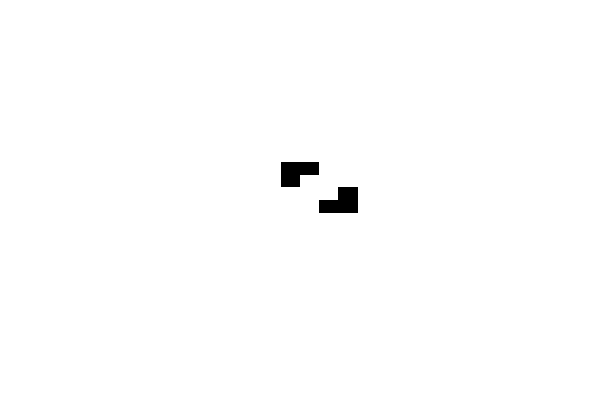

In [81]:
N = 30 #the size of our grid
num_gens = 40 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 1 ; 0 0 0 1 ; 1 0 0 0 ; 1 1 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original GoL beacon.gif")

In [82]:
#make hamming distance plot
title = "Original GoL beacon"
filename = "$(title).png"
hamming_ts = calculate_hamming_ts(test1_history)
occupancy_ts = calculate_occupancy(test1_history)
hamming_plot = plot(hamming_ts,title = title,xlabel = "timestep",ylabel = "Hamming Distance")
occupancy_plot = plot(occupancy_ts,title = title,xlabel = "timestep",ylabel = "Occupancy Plot")
final_plot = plot(hamming_plot,occupancy_plot,figsize = (20,5))
savefig(final_plot,filename)

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original GoL glider.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original GoL glider.gif")
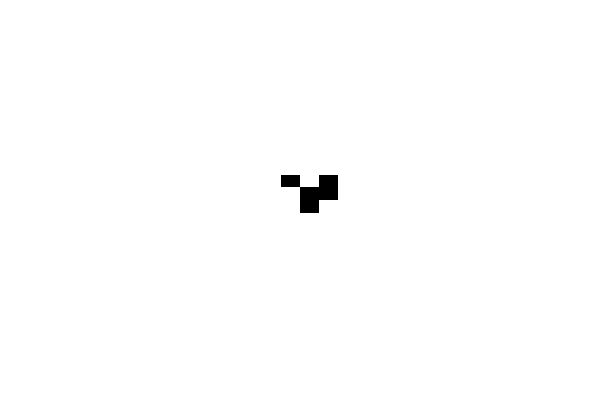

In [118]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;0 1 1 ; 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original GoL glider.gif")

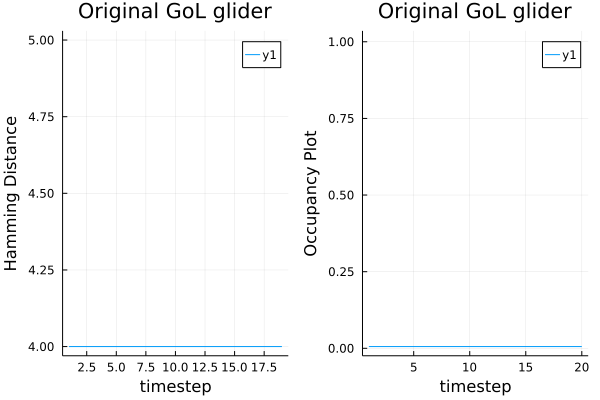

In [119]:
#make hamming distance plot
title = "Original GoL glider"
filename = "$(title).png"
hamming_ts = calculate_hamming_ts(test1_history)
occupancy_ts = calculate_occupancy(test1_history)
hamming_plot = plot(hamming_ts,title = title,xlabel = "timestep",ylabel = "Hamming Distance")
occupancy_plot = plot(occupancy_ts,title = title,xlabel = "timestep",ylabel = "Occupancy Plot")
final_plot = plot(hamming_plot,occupancy_plot,figsize = (20,5))
#savefig(final_plot,filename)

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original GoL LWSS.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original GoL LWSS.gif")
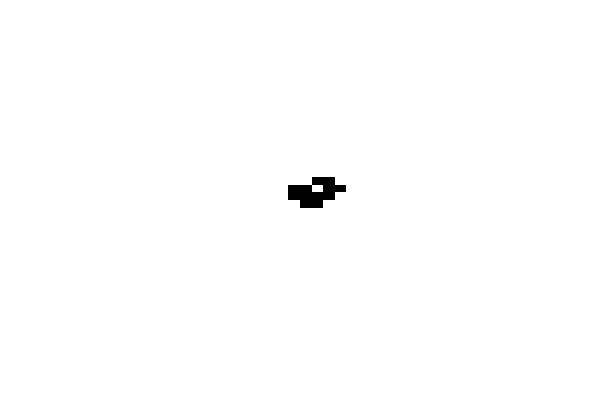

In [84]:
N = 50 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 0 0 ;1 1 1 1 0 ; 1 1 0 1 1 ; 0 0 1 1 0 ; 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original GoL LWSS.gif")

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original GoL MWSS.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original GoL MWSS.gif")
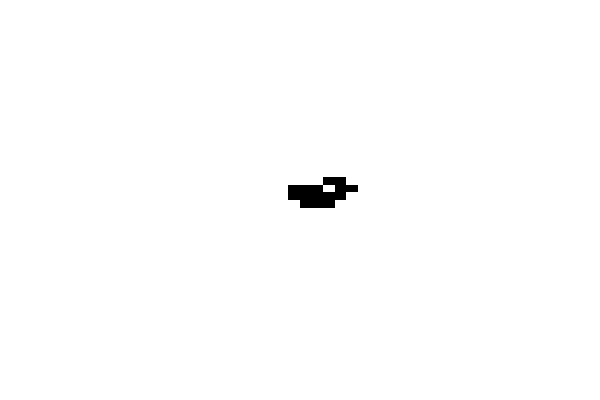

In [121]:
N = 50 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+5 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 0 0 ;1 1 1 1 1 0 ; 1 1 1 0 1 1 ; 0 0 0 1 1 0 ; 0 0 0 0 0 0 ; 0 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original GoL MWSS.gif")

In [123]:
#make hamming distance plot
title = "Original GoL MWSS"
filename = "$(title).png"
hamming_ts = calculate_hamming_ts(test1_history)
occupancy_ts = calculate_occupancy(test1_history)
hamming_plot = plot(hamming_ts,title = title,xlabel = "timestep",ylabel = "Hamming Distance")
occupancy_plot = plot(occupancy_ts,title = title,xlabel = "timestep",ylabel = "Occupancy Plot")
final_plot = plot(hamming_plot,occupancy_plot,figsize = (20,5))
savefig(final_plot,filename)

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original GoL HWSS.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Original GoL HWSS.gif")
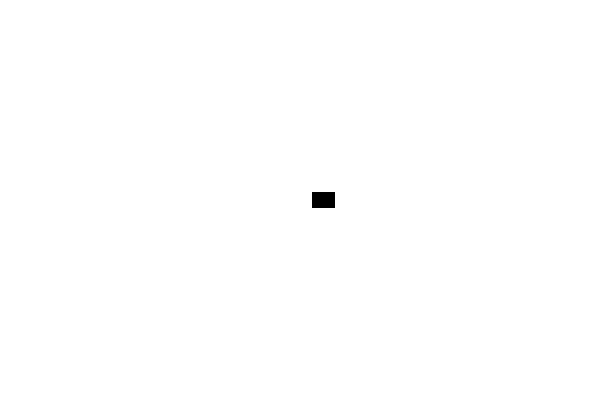

In [89]:
N = 50 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 1 0 0 0 ;0 0 1 1 0 0 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original GoL HWSS.gif")

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Alt1 rule with inf pattern1.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Alt1 rule with inf pattern1.gif")
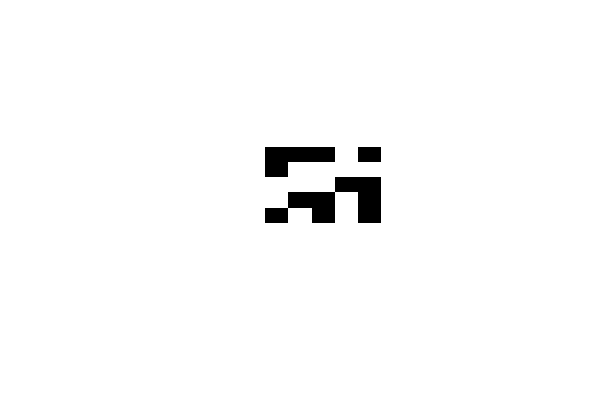

In [90]:
function game_of_life_update_v1(neighborhood)
    """
    Given an array of values of the neighborhood of a cell, calculate the updated value of the cell according to Conway's Game of life: https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life
    inputs:
        neighborhood<matrix> a matrix of the neighborhood around a cell
    returns: 
        return_condition<int>: the conidition of the updated cell at index i,j, 0 if dead, 1 if alive
    """
    my_cell = neighborhood[2,2]
    return_condition = 0#the state of the current cell to reuturn from this function

    #if the cell is alive
    if my_cell == 1
        alive_neighbors = sum(neighborhood)-1#the number of neighbors who are alive_neighborohood, subtract one to account for the cell itself.
        #determine status of current cell based on status of neighboring cells
        if 0 < alive_neighbors < 3 #if the number of alive_neighbors is equal to 1 or 2, the cell remains alive
            return_condition = 1
        end
    end
    #if cell is dead 
    if my_cell == 0
        alive_neighbors = sum(neighborhood)
        if alive_neighbors == 3
            return_condition = 1
        end
    end
    
#println(return_condition)
return return_condition
end


N = 25#the size of our grid
num_gens = 50#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1;0 1 1 0 1; 0 0 0 1 1;1 0 0 0 0;1 1 1 0 1]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule with inf pattern1.gif")

In [91]:
#make hamming distance plot
title = "Alt1 rule with inf pattern1"
filename = "$(title).png"
hamming_ts = calculate_hamming_ts(test1_history)
occupancy_ts = calculate_occupancy(test1_history)
hamming_plot = plot(hamming_ts,title = title,xlabel = "timestep",ylabel = "Hamming Distance")
occupancy_plot = plot(occupancy_ts,title = title,xlabel = "timestep",ylabel = "Occupancy Plot")
final_plot = plot(hamming_plot,occupancy_plot,figsize = (20,5))
savefig(final_plot,filename)

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Alt1 rule with inf pattern2.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Alt1 rule with inf pattern2.gif")
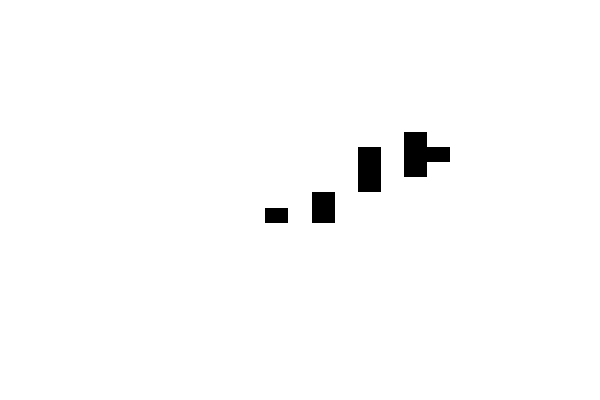

In [109]:
N = 25#the size of our grid
num_gens = 35#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+7#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 0 0 0 0 ;0 0 1 0 0 0 0 0 ;0 0 0 0 1 0 0 0 ;0 0 0 0 1 0 1 0 ;0 0 0 0 1 0 1 1 ;0 0 0 0 0 0 1 0 ;0 0 0 0 0 0 0 0 ;0 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule with inf pattern2.gif")

In [ ]:
N = 80#the size of our grid
num_gens = 40#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+38#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin] = [1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 ]
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule inf pattern3.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 40 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 1 ; 0 0 0 1 ; 1 0 0 0 ; 1 1 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule beacon.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 40#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 0 ;1 0 0 1 ; 0 1 1 0; 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule beehive.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 40#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 0 ;0 1 0 1 ; 1 0 0 1; 0 1 1 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule loaf.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 10#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;1 0 1 ; 1 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule boat.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 10#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;1 0 1 ; 0 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule tub.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 10#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 0 ;1 1 1 ; 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule blinker.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;0 1 1 ; 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"test9.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 ;0 0 1 ; 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"test9.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 1 0 ;0 1 1 ; 1 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"test9.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 1 1 ;0 0 1 ; 0 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"test9.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 0 0 ;1 1 1 1 0 ; 1 1 0 1 1 ; 0 0 1 1 0 ; 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule LWSS.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+5 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 0 0 ;1 1 1 1 1 0 ; 1 1 1 0 1 1 ; 0 0 0 1 1 0 ; 0 0 0 0 0 0 ; 0 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule MWSS.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 1 0 0 ;1 1 1 1 1 1 0 ; 1 1 1 1 0 1 1 ; 0 0 0 0 1 1 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule HWSS.gif")

In [ ]:
### NEW RULE

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Alt2 rule inf pattern1.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Alt2 rule inf pattern1.gif")
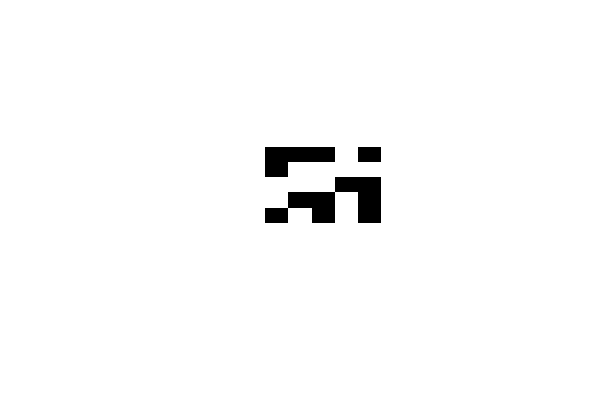

In [107]:
function game_of_life_update_v2(neighborhood)
    """
    Given an array of values of the neighborhood of a cell, calculate the updated value of the cell according to Conway's Game of life: https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life
    inputs:
        neighborhood<matrix> a matrix of the neighborhood around a cell
    returns: 
        return_condition<int>: the conidition of the updated cell at index i,j, 0 if dead, 1 if alive
    """
    my_cell = neighborhood[2,2]
    return_condition = 0#the state of the current cell to reuturn from this function

    #if the cell is alive
    if my_cell == 1
        alive_neighbors = sum(neighborhood)-1#the number of neighbors who are alive_neighborohood, subtract one to account for the cell itself.
        #determine status of current cell based on status of neighboring cells
        if 2 < alive_neighbors < 5 #if the number of alive_neighbors is equal to 3 or 4, the cell remains alive
            return_condition = 1
        end
    end
    #if cell is dead 
    if my_cell == 0
        alive_neighbors = sum(neighborhood)
        if alive_neighbors == 3
            return_condition = 1
        end
    end
    
#println(return_condition)
return return_condition
end


N = 25#the size of our grid
num_gens = 10#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1;0 1 1 0 1; 0 0 0 1 1;1 0 0 0 0;1 1 1 0 1]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule inf pattern1.gif")

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Alt2 rule inf pattern 2.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Alt2 rule inf pattern 2.gif")
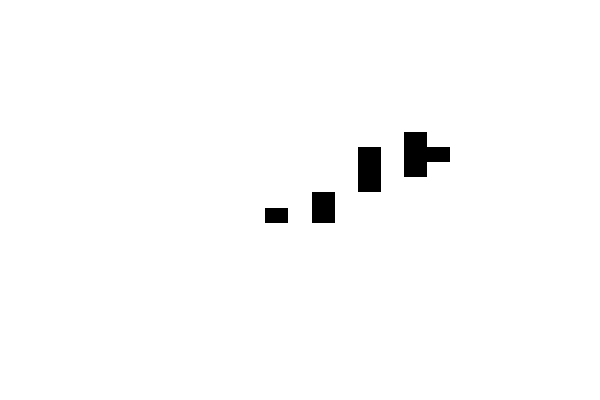

In [110]:
N = 25#the size of our grid
num_gens = 35#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+7#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 0 0 0 0 ;0 0 1 0 0 0 0 0 ;0 0 0 0 1 0 0 0 ;0 0 0 0 1 0 1 0 ;0 0 0 0 1 0 1 1 ;0 0 0 0 0 0 1 0 ;0 0 0 0 0 0 0 0 ;0 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule inf pattern 2.gif")

In [111]:
#make hamming distance plot
title = "Alt2 rule with inf pattern1"
filename = "$(title).png"
hamming_ts = calculate_hamming_ts(test1_history)
occupancy_ts = calculate_occupancy(test1_history)
hamming_plot = plot(hamming_ts,title = title,xlabel = "timestep",ylabel = "Hamming Distance")
occupancy_plot = plot(occupancy_ts,title = title,xlabel = "timestep",ylabel = "Occupancy Plot")
final_plot = plot(hamming_plot,occupancy_plot,figsize = (20,5))
savefig(final_plot,filename)

In [ ]:
N = 80#the size of our grid
num_gens = 30#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+38#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin] = [1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 ]
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule inf pattern 3.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 30#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 1 ; 0 0 0 1 ; 1 0 0 0 ; 1 1 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule beacon.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 30#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 0 ;0 1 0 1 ; 1 0 0 1; 0 1 1 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule loaf.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 10#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;1 0 1 ; 1 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule boat.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 0 0 ;1 1 1 1 0 ; 1 1 0 1 1 ; 0 0 1 1 0 ; 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule LWSS.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+5 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 0 0 ;1 1 1 1 1 0 ; 1 1 1 0 1 1 ; 0 0 0 1 1 0 ; 0 0 0 0 0 0 ; 0 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule MWSS.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 1 0 0 ;1 1 1 1 1 1 0 ; 1 1 1 1 0 1 1 ; 0 0 0 0 1 1 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule HWSS.gif")

In [ ]:
### trying to find new structures in Alt1 rule

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 1 1 1 1 1 1 ; 1 1 1 1 1 1 1 ; 1 1 0 1 0 1 1 ; 1 1 1 1 1 1 1 ; 1 1 0 1 0 1 1 ; 1 1 1 1 1 1 1 ; 1 1 1 1 1 1 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule square with gaps.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule 4 lines.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ; 1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ; 1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ; 1 0 1 0 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule checker.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ; 0 1 0 1 0 1 0 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule staggered checker.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 0 0 1 0 1 ; 1 0 0 0 1 0 1 ; 1 1 0 1 0 1 0 ; 0 0 1 0 0 1 0 ; 1 1 0 1 1 0 0 ; 0 0 0 1 1 0 0 ; 0 1 0 1 0 1 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule random1.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 0 0 1 0 0 1 0 ; 1 1 0 1 1 0 0 ; 1 0 0 0 1 0 1 ; 1 0 0 0 1 0 1 ; 1 1 0 1 0 1 0 ;0 0 0 1 1 0 0 ; 0 1 0 1 0 1 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule random2.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 40 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 1 1 1 0 0 0 0 ; 1 1 0 0 0 1 1 ; 1 1 0 1 0 1 0 ; 1 0 1 1 0 0 0 ; 0 0 0 0 0 1 0 ; 0 1 1 0 0 1 1 ; 1 1 0 1 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule random3.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 40 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 0 0 0 0 ;0 1 1 0 0 0 0 ;1 1 0 1 1 0 0 ;1 0 0 1 1 0 0 ;0 1 1 1 0 1 1 ;0 1 1 0 0 1 1 ;0 0 0 1 1 1 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule random4.gif")

In [ ]:
### trying to find new structures in Alt2 rule

In [ ]:
N = 30 #the size of our grid
num_gens = 50 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 1 1 1 0 1 0 0 ; 1 1 0 0 0 1 1 ; 1 1 0 1 0 1 0 ; 1 0 1 1 0 0 0 ; 0 0 0 0 0 1 0 ; 0 1 1 0 1 1 1 ; 1 1 0 1 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule random1 period 16.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 17#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 1 0 ;1 1 1 ; 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule period 16.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+5 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 0 1 1 0 ; 1 1 0 1 1 0 ; 1 1 1 1 0 0 ; 0 0 1 1 1 1 ; 0 1 1 0 1 1 ;0 1 1 0 0 0 ] #take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule 4 period 16.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+5 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 1 1 0 ; 1 1 0 0 1 0 ; 1 0 1 1 0 1 ; 1 0 1 1 0 1 ; 0 1 0 0 1 1 ;0 1 1 1 0 0 ] #take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule ls square.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+7 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 0 0 0 1 1 0 0 0;0 0 0 1 1 0 0 0 ;0 0 0 1 0 0 0 0 ;1 1 0 0 0 1 1 1; 1 1 1 0 0 0 1 1; 0 0 0 1 0 0 0 0; 0 0 0 1 1 0 0 0; 0 0 0 1 1 0 0 0] #take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule 4 period 16 take2.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 0 0 1 1 0 0 0; 0 0 1 1 0 0 0 ; 1 1 0 1 0 0 0 ; 1 1 1 0 1 1 1 ; 0 0 0 1 0 1 1; 0 0 0 1 1 0 0; 0 0 0 1 1 0 0] #take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule 4 period 16 take3.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+7 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 0 0 0 0 1 1 0 0; 0 0 0 0 1 1 0 0 ; 0 0 0 0 1 0 1 1 ; 0 0 0 0 0 1 1 1 ; 1 1 1 0 0 0 0 0 ; 1 1 0 1 0 0 0 0; 0 0 1 1 0 0 0 0 ; 0 0 1 1 0 0 0 0] #take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule 4 period 16 take4.gif")

In [ ]:
### The next version is varying how many alive cells need to be around a dead cell for one to be flipped on
### Changing the rebirth rate for Alt1 rule to 2 so 


┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/yeah.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/yeah.gif")
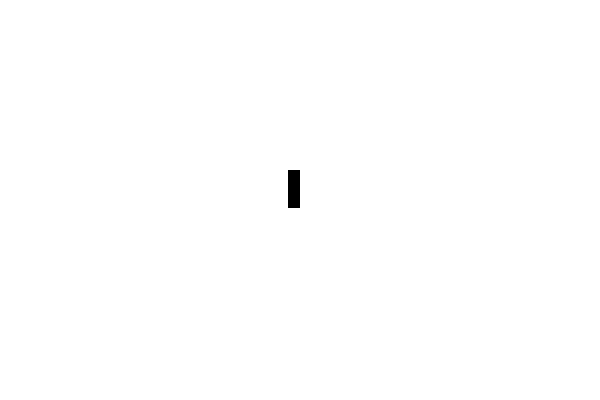

In [112]:
function game_of_life_update_v3(neighborhood)
    """
    Given an array of values of the neighborhood of a cell, calculate the updated value of the cell according to Conway's Game of life: https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life
    inputs:
        neighborhood<matrix> a matrix of the neighborhood around a cell
    returns: 
        return_condition<int>: the conidition of the updated cell at index i,j, 0 if dead, 1 if alive
    """
    my_cell = neighborhood[2,2]
    return_condition = 0#the state of the current cell to reuturn from this function

    #if the cell is alive
    if my_cell == 1
        alive_neighbors = sum(neighborhood)-1#the number of neighbors who are alive_neighborohood, subtract one to account for the cell itself.
        #determine status of current cell based on status of neighboring cells
        if 0 < alive_neighbors < 3 #if the number of alive_neighbors is equal to 2 or 3, the cell remains alive
            return_condition = 1
        end
    end
    #if cell is dead 
    if my_cell == 0
        alive_neighbors = sum(neighborhood)
        if alive_neighbors ==2 
            return_condition = 1
        end
    end
    
#println(return_condition)
return return_condition
end


N = 50#the size of our grid
num_gens = 50#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin] = [1 1 1 1 1]
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"yeah.gif")

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Alt3 rule with inf pattern1.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Alt3 rule with inf pattern1.gif")
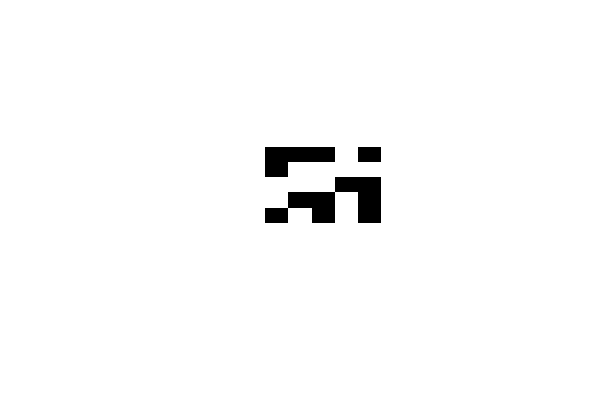

In [113]:
N = 25#the size of our grid
num_gens = 50#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1;0 1 1 0 1; 0 0 0 1 1;1 0 0 0 0;1 1 1 0 1]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule with inf pattern1.gif")

┌ Info: Saved animation to 
│   fn = /Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Alt3 rule with inf pattern2.gif
└ @ Plots /Users/willthompson/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/willthompson/Documents/CSDS/MOCS/Project1/MOCS/project2/Alt3 rule with inf pattern2.gif")
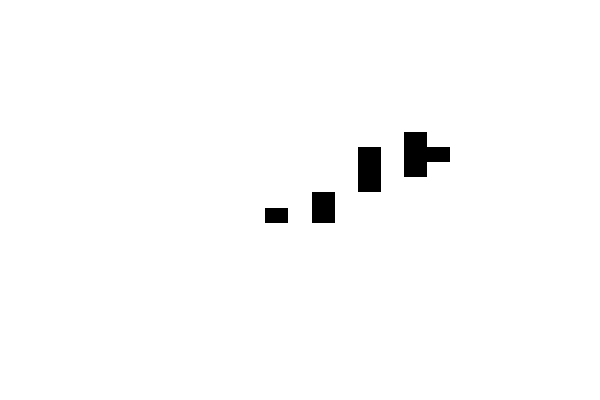

In [114]:
N = 25#the size of our grid
num_gens = 35#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+7#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 0 0 0 0 ;0 0 1 0 0 0 0 0 ;0 0 0 0 1 0 0 0 ;0 0 0 0 1 0 1 0 ;0 0 0 0 1 0 1 1 ;0 0 0 0 0 0 1 0 ;0 0 0 0 0 0 0 0 ;0 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule with inf pattern2.gif")

In [115]:
#make hamming distance plot
title = "Alt3 rule with inf pattern1"
filename = "$(title).png"
hamming_ts = calculate_hamming_ts(test1_history)
occupancy_ts = calculate_occupancy(test1_history)
hamming_plot = plot(hamming_ts,title = title,xlabel = "timestep",ylabel = "Hamming Distance")
occupancy_plot = plot(occupancy_ts,title = title,xlabel = "timestep",ylabel = "Occupancy Plot")
final_plot = plot(hamming_plot,occupancy_plot,figsize = (20,5))
savefig(final_plot,filename)

In [ ]:
#make hamming distance plot
title = "Alt2 rule with inf pattern1"
filename = "$(title).png"
hamming_ts = calculate_hamming_ts(test1_history)
occupancy_ts = calculate_occupancy(test1_history)
hamming_plot = plot(hamming_ts,title = title,xlabel = "timestep",ylabel = "Hamming Distance")
occupancy_plot = plot(occupancy_ts,title = title,xlabel = "timestep",ylabel = "Occupancy Plot")
final_plot = plot(hamming_plot,occupancy_plot,figsize = (20,5))
savefig(final_plot,filename)

In [ ]:
N = 80#the size of our grid
num_gens = 40#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+38#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin] = [1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 ]
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule inf pattern3.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 40 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 1 ; 0 0 0 1 ; 1 0 0 0 ; 1 1 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule beacon.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 40#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 0 ;1 0 0 1 ; 0 1 1 0; 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule beehive.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 40#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 0 ;0 1 0 1 ; 1 0 0 1; 0 1 1 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule loaf.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 40#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;1 0 1 ; 1 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule boat.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 30#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;1 0 1 ; 0 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule tub.gif")

In [ ]:
N = 30#the size of our grid
num_gens = 30#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 0 ;1 1 1 ; 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule blinker.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;0 1 1 ; 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule glider.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 0 0 ;1 1 1 1 0 ; 1 1 0 1 1 ; 0 0 1 1 0 ; 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule LWSS.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+5 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 0 0 ;1 1 1 1 1 0 ; 1 1 1 0 1 1 ; 0 0 0 1 1 0 ; 0 0 0 0 0 0 ; 0 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule MWSS.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 1 0 0 ;1 1 1 1 1 1 0 ; 1 1 1 1 0 1 1 ; 0 0 0 0 1 1 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule HWSS.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 1 1 1 1 1 1 ; 1 1 1 1 1 1 1 ; 1 1 0 1 0 1 1 ; 1 1 1 1 1 1 1 ; 1 1 0 1 0 1 1 ; 1 1 1 1 1 1 1 ; 1 1 1 1 1 1 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule square with gaps.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule 4 lines.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ; 1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ; 1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ; 1 0 1 0 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule checker.gif")

In [ ]:
N = 30 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ; 0 1 0 1 0 1 0 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule staggered checker.gif")

In [ ]:
N = 40 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 0 0 1 0 1 ; 1 0 0 0 1 0 1 ; 1 1 0 1 0 1 0 ; 0 0 1 0 0 1 0 ; 1 1 0 1 1 0 0 ; 0 0 0 1 1 0 0 ; 0 1 0 1 0 1 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule random1.gif")

In [ ]:
N = 40 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 0 0 1 0 0 1 0 ; 1 1 0 1 1 0 0 ; 1 0 0 0 1 0 1 ; 1 0 0 0 1 0 1 ; 1 1 0 1 0 1 0 ;0 0 0 1 1 0 0 ; 0 1 0 1 0 1 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule random2.gif")

In [ ]:
N = 40 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 0 0 1 0 0; 0 0 0 0 0 ; 0 0 1 0 0 ; 0 0 0 0 0 ; 0 0 1 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"yeah.gif")

In [ ]:
N = 40 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 0 0 1 0 0; 0 0 0 0 0 ; 0 0 1 0 0 ; 0 0 0 0 0 ; 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"yeah.gif")

In [ ]:
N = 50 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule 4 lines.gif")

In [ ]:
N = 40 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 1 0 0 0 1; 0 0 0 0 0 ; 0 0 1 0 0 ; 0 0 0 0 0 ; 1 0 0 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"Alt3 rule dots.gif")